## Example 1.
### Sensitivity of hydraulic head at a point to <font color='blue'>spatially uniform hydraulic conductivity</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}+R=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad -K\ b\ \frac{dh(x)}{dx}=0\ ,\quad\quad\;\;\, x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad h(x)=h_{\Gamma_1}\ ,\quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad h(x)=h_L+\frac{R (L^2-x^2)}{2\ K\ b}
\cr\cr\end{align}$

Spatial derivatives of hydraulic head obtained from differentiation:

$\begin{align}
\quad\quad \frac{d h}{d x}=-\frac{R\ x}{K\ b},\quad\quad \frac{d^2 h}{d x^2}{}=-\frac{R}{K\ b}
\cr\end{align}$

In [1]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

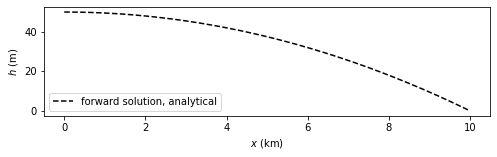

In [13]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

def h(x, K, R, b, L, BC1h):
    return R/K/2./b*(L**2.-x**2.)

K, R, b, L, BC1h, ocol = 10., 1e-1/1000., 10., 10000., 0., 5000
X = np.arange(L)
H0 = np.array([h(x, K, R, b, L, BC1h) for x in X])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

## 1. Direct sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial K}=\frac{R\ (x^2-L^2)}{2\ K^2\ b}
\cr\cr\end{align}$

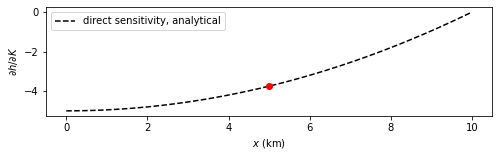

In [14]:
dhdK = [R/K**2./2./b*(x**2.-L**2.) for x in X]
benchmark = dhdK[ocol]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='direct sensitivity, analytical')
plt.plot(ocol/1000., dhdK[ocol], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [15]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% benchmark)

-3.750000


## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial K}\approx\frac{h(x,K+\Delta K)-h(x,K)}{\Delta K}\;
\cr\cr\end{align}$

### 2a. Analytical

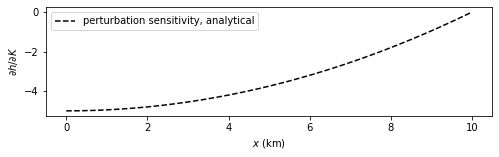

In [16]:
dpar = 1e-4
H0 = np.array([h(x, K, R, b, L, BC1h) for x in X])
H1 = np.array([h(x, K+K*dpar, R, b, L, BC1h) for x in X])
dhdK = (H1-H0)/(K*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='perturbation sensitivity, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [17]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[ocol], benchmark))

-3.749625 (-3.750000)


### 2b. Semi-analytical

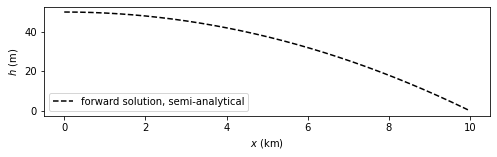

In [40]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.StripAreaSink(M0, 0., L, R)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

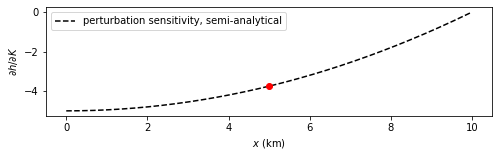

In [19]:
M1 = timml.Model3D(kaq=K+K*dpar, z=[0., -b])
timml.ImpLineDoublet1D(M1, xld=0.)
timml.HeadLineSink1D(M1, xls=L, hls=0.)
timml.StripAreaSink(M1, 0., L, R)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdK = (H1-H0)/(K*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.plot(ocol/1000., dhdK[ocol], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [20]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[ocol], benchmark))

-3.749625 (-3.750000)


### 2c. Numerical

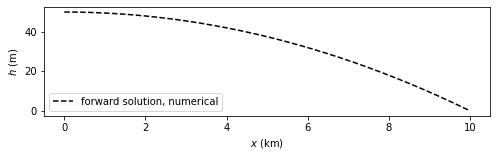

In [21]:
import flopy

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

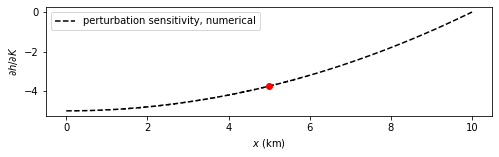

In [22]:
M1 = M0
flopy.modflow.ModflowLpf(M1, hk=K+K*dpar, vka=-999., ss=-999., sy=-999., ipakcb=53)
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdK = (H1-H0)/(K*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.plot(ocol/1000., dhdK[ocol], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [23]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[ocol], benchmark))

-3.753662 (-3.750000)


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial K}=\int\limits_X\psi^*_1(x)\ b\ \frac{d^2 h(x)}{d x^2}\; dx
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad -K\ b\ \frac{d\psi^*_1(x)}{dx}=0\ ,\quad\quad\; x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\ \quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad \psi^*_1(x)=\frac{1}{2\ K\ b}\left[H\left(x'-x\right)\left(L-x'\right)+H\left(x-x'\right)\left(L-x\right)\right]
\cr\end{align}$

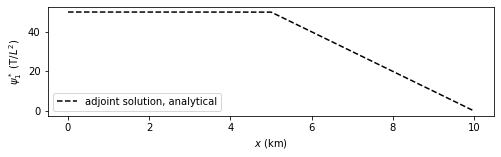

In [24]:
def a(x, xp, K, b, L):
    if x>xp:
        a = L-x
    else:
        a = L-xp
    return a/K/b
A = np.array([a(x, ocol, K, b, L) for x in X])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

### 3a. Analytical

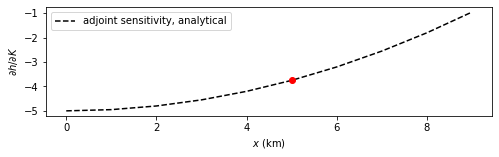

In [25]:
dhdK = [np.sum(np.array([a(x, xp, K, b, L) for x in X])*b*-R/(K*b)) for xp in X[::1000]]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdK, 'k--', mfc='none', label='adjoint sensitivity, analytical')
plt.plot(ocol/1000., dhdK[int(ocol/1000)], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [26]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

-3.750250 (-3.750000)


### 3b. Semi-analytical

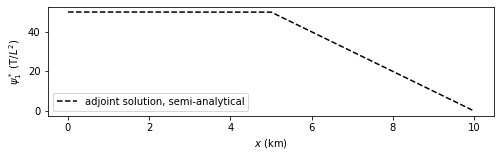

In [27]:
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

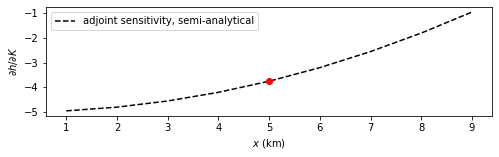

In [28]:
dhdK = np.empty(0)
for xp in X[::1000]:
    M0 = timml.Model3D(kaq=K, z=[0., -b])
    timml.ImpLineDoublet1D(M0, xld=0.)
    timml.HeadLineSink1D(M0, xls=L, hls=0.)
    timml.LineSink1D(M0, xls=xp, sigls=-1.)
    M0.solve(silent=True)
    A = M0.headalongline(X, 0.).flatten() 
    dhdK = np.append(dhdK, np.sum(A*b*-R/(K*b)))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000][1:]/1000., dhdK[1:], 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.plot(ocol/1000., dhdK[int(ocol/1000)], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend(loc=2);

In [29]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

-3.750250 (-3.750000)


### 3c. Numerical, continuous

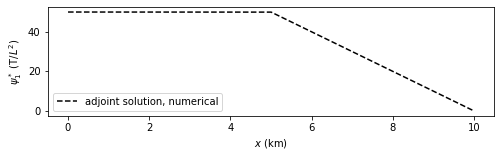

In [30]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=1, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=np.zeros([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

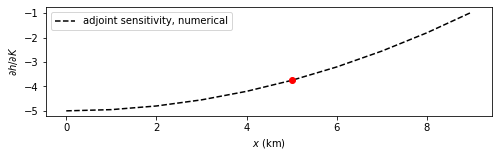

In [31]:
dhdK = np.empty(0)
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, oc*1000, 1.]})
    M1.write_input()
    success, buff = M1.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
    dhdK = np.append(dhdK, np.sum(A*b*-R/(K*b)))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdK, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.plot(ocol/1000., dhdK[int(ocol/1000)], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [32]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdK[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

-3.749250 (-3.750000)


### 3d. Numerical, discrete

Re-run adjoint model to obtain the adjoint state vector, $\psi^*_1$:

In [33]:
M1 = M0
flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, ocol, 1.]})
M1.write_input()
success, buff = M1.run_model(silent=True)
psi = np.atleast_2d(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:])
np.shape(psi)

(1, 10000)

Re-run forward model to obtain vectors of output heads, $h$, cell-by-cell conductances, $CR$, and RHS terms, $RHS$ :

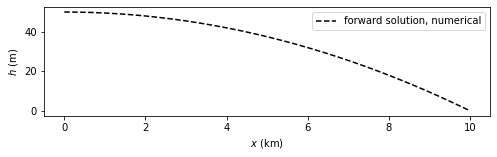

In [34]:
import flopy
from os import system

nrow, ncol = 1, 10000
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
#success, buff = M0.run_model(silent=True)
system('mf2005_stream.exe < model.in')
h = np.atleast_2d(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
#plt.plot(X/1000., h[0, range(500, np.shape(h)[1], 1000)], 'ko--', mfc='none', label='forward solution, numerical')
plt.plot(X/1000., np.ravel(h), 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

Import RHS vector:

In [35]:
RHS = np.atleast_2d(np.loadtxt('RHS.arr').flatten())
print(np.shape(RHS))

(1, 10000)


Assemble A matrix from CR vector terms:

In [36]:
'''CR = np.reshape(np.loadtxt('CR.arr').flatten(), [1,ncol])
CR = np.vstack([np.zeros(ncol),       CR, np.zeros(ncol)])
CR = np.hstack([np.zeros([nrow+2,1]), CR, np.zeros([nrow+2,1])])
A = np.zeros([nrow*ncol, nrow*ncol])
i = 0
for r in range(1, nrow+1):
    for c in range(1, ncol+1):
        if i-1 > -1:
            A[i,i-1] = CR[r,c-1]
        A[i,i] = -CR[r,c-1]-CR[r,c]
        if i+1 < nrow*ncol-1:
            A[i,i+1] = CR[r,c]
        i +=1
A[-1,-1] = 0.
dAdK = A/K
print(dAdK)
A = None''';

Assemble A matrix analytically:

In [37]:
from scipy.sparse import dia_matrix
n = int(L)
ex = np.ones(n)
data = np.array([ex*b, ex*-2.*b, ex*b])
offsets = np.array([-1, 0, 1])
dAdK = dia_matrix((data, offsets), shape=(n, n)).toarray()
dAdK[0,0] = -b
#dAdK_test[:,-1] = 0.
#dAdK_test[-1,:] = 0.
print(dAdK)

[[-10.  10.   0. ...   0.   0.   0.]
 [ 10. -20.  10. ...   0.   0.   0.]
 [  0.  10. -20. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -20.  10.   0.]
 [  0.   0.   0. ...  10. -20.  10.]
 [  0.   0.   0. ...   0.  10. -20.]]


In [69]:
print(psi.shape, h.shape, dAdK.shape)

(1, 10000) (1, 10000) (10000, 10000)


In [38]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (np.float(-psi@dAdK@h.T), benchmark))

3.749250 (-3.750000)


In [39]:
set_background('rgba(200, 0, 0, 0.2)')
print(' \n!!! IGNORE WORKINGS BELOW !!!\n ')

 
!!! IGNORE WORKINGS BELOW !!!
 


Assemble A matrix and RHS vector:

In [ ]:
CR = np.reshape(np.loadtxt('CR.arr').flatten(), [1,ncol])
CR = np.vstack([np.zeros(ncol),       CR, np.zeros(ncol)])
CR = np.hstack([np.zeros([nrow+2,1]), CR, np.zeros([nrow+2,1])])
CC  = np.zeros(np.shape(CR))
A = np.zeros([nrow*ncol, nrow*ncol])
i = 0
for r in range(1, nrow+1):
    for c in range(1, ncol+1):
        if r==nrow and c==ncol:
            continue
        if i-ocol > -1:
            A[i, i-ocol] = CC[r-1,c]
        if i-1 > -1:
            A[i, i-1] = CR[r,c-1]
        A[i, i] = -CC[r-1,c]-CR[r,c-1]-CC[r,c]-CR[r,c]
        if i+1 < nrow*ncol-1:
            A[i, i+1] = CR[r,c]
        if i+ocol < nrow*ncol-1:
            A[i, i+ocol] = CC[r,c]
        i +=1
#A = A[:-1,:-1]
print(A)

In [ ]:
RHS = np.atleast_2d(np.loadtxt('RHS.arr'))
print(np.shape(RHS))

In [ ]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
#success, buff = M0.run_model(silent=True)
system('mf2005_stream.exe < model.in')

h = np.reshape(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:], [1,ncol]).T
CR = np.reshape(np.loadtxt('CR.arr').flatten(), [1,ncol])
CR = np.vstack([np.zeros(ncol),       CR, np.zeros(ncol)])
CR = np.hstack([np.zeros([nrow+2,1]), CR, np.zeros([nrow+2,1])])
CC  = np.zeros(np.shape(CR))
A = np.zeros([nrow*ncol, nrow*ncol])
i = 0
for r in range(1, nrow+1):
    for c in range(1, ncol+1):
        if i-1 > -1:
            A[i,i-1] = CR[r,c-1]
        A[i,i] = -CR[r,c-1]-CR[r,c]
        if i+1 < nrow*ncol-1:
            A[i,i+1] = CR[r,c]
        i +=1
A[-1,-1] = 0.
A0 = A
print(A0)

In [ ]:
from scipy.sparse import dia_matrix
n = 10000
ex = np.ones(n)
data = np.array([100*ex, -200*ex, 100*ex])
offsets = np.array([-1, 0, 1])
test = dia_matrix((data, offsets), shape=(n, n)).toarray()

In [ ]:
dpar = 1e-4
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K+K*dpar, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
#success, buff = M0.run_model(silent=True)
system('mf2005_stream.exe < model.in')

h = np.reshape(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:], [1,ncol]).T
CR = np.reshape(np.loadtxt('CR.arr').flatten(), [1,ncol])
CR = np.vstack([np.zeros(ncol),       CR, np.zeros(ncol)])
CR = np.hstack([np.zeros([nrow+2,1]), CR, np.zeros([nrow+2,1])])
CC  = np.zeros(np.shape(CR))
A = np.zeros([nrow*ncol, nrow*ncol])
i = 0
for r in range(1, nrow+1):
    for c in range(1, ncol+1):
        if i-1 > -1:
            A[i,i-1] = CR[r,c-1]
        A[i,i] = -CR[r,c-1]-CR[r,c]
        if i+1 < nrow*ncol-1:
            A[i,i+1] = CR[r,c]
        i +=1
A1 = A
print(A1)

In [ ]:
dAdK = (A1-A0)/(K*dpar)

In [ ]:
dAdK

In [ ]:
psi

In [ ]:
dAdK

In [ ]:
h

In [ ]:
np.float(-psi@dAdK@h)

In [ ]:
np.shape(psi), np.shape(dAdK), np.shape(h)

In [ ]:
h_analyt = np.atleast_2d([R/K/2./b*(L**2.-x**2.) for x in X]).T
dhdK_analyt = np.atleast_2d([R/K**2./2./b*(x**2.-L**2.) for x in [5000.]])
def a(x, xp, K, b, L):
    if x>xp:
        a = L-x
    else:
        a = L-xp
    return a/K/b
psi_analyt = np.atleast_2d([a(x, ocol, K, b, L) for x in X])

In [ ]:
psi_analyt_inv = np.linalg.pinv(psi_analyt)
h_analyt_inv = np.linalg.pinv(h_analyt)

In [ ]:
np.shape(psi_analyt_inv)

In [ ]:
dAdK_analyt = -psi_analyt_inv@dhdK_analyt@h_analyt_inv

In [ ]:
np.float(-psi_analyt@dAdK_analyt@h_analyt)

In [ ]:
np.shape(dAdK_analyt)

In [ ]:
np.float(-psi@test@h)

In [ ]:
psi.shape

In [ ]:
h.shape

In [ ]:
test.shape

In [ ]:
def min_test(pars):
    print(pars)
    global psi, h
    n = 10000
    ex = np.ones(n)
    data = np.array([ex*pars[0], ex*pars[1], ex*pars[2]])
    offsets = np.array([-1, 0, 1])
    dhdA_test = dia_matrix((data, offsets), shape=(n, n)).toarray()
    return -3.75-np.float(-psi@dhdA_test@h)

In [ ]:
from scipy.optimize import least_squares
pars0 = np.array([1., 1., 1.])
res = least_squares(min_test, pars0)

In [ ]:
n = 10000
ex = np.ones(n)
data = np.array([ex*res.x[0], ex*res.x[1], ex*res.x[2]])
offsets = np.array([-1, 0, 1])
dhdA_opt = dia_matrix((data, offsets), shape=(n, n)).toarray()

In [ ]:
dhdA_opt

In [ ]:
-psi@dhdA_opt@h

In [ ]:
res.x*K*dpar

In [ ]:
CR = np.atleast_2d(np.loadtxt('CR.arr').flatten())
CR = np.vstack([np.zeros(ncol),       CR, np.zeros(ncol)])
CR = np.hstack([np.zeros([nrow+2,1]), CR, np.zeros([nrow+2,1])])
np.shape(CR)

In [ ]:
np.unique(RHS)

In [ ]:
h.shape

In [ ]:
def min_test(pars):
    print(pars)
    global psi, h
    n = 10000
    ex = np.ones(n)
    data = np.array([ex*pars, ex*-2.*pars, ex*pars])
    offsets = np.array([-1, 0, 1])
    dhdA_test = dia_matrix((data, offsets), shape=(n, n)).toarray()
    dhdA_test[0,0] = -pars
    dhdA_test[:,-1] = 0.
    dhdA_test[-1,:] = 0.
    return -3.75-np.float(-psi@dhdA_test@h)

from scipy.optimize import least_squares
pars0 = 1.
res = least_squares(min_test, pars0)

In [ ]:
dpar

In [ ]:
h

In [ ]:
RHS

In [ ]:
A

In [ ]:
psi.shape

In [ ]:
h.shape

In [ ]:
A.shape

In [ ]:
dAdK.shape

In [ ]:
dAdK

In [ ]:
n = 10000
ex = np.ones(n)
data = np.array([ex*b, ex*-2.*b, ex*b])
offsets = np.array([-1, 0, 1])
dhdA_test = dia_matrix((data, offsets), shape=(n, n)).toarray()
dhdA_test[0,0] = -b
#dhdA_test[:,-1] = 0.
#dhdA_test[-1,:] = 0.
np.float(-psi@dhdA_test@h)


In [ ]:
dhdA_test